EPITA 2023 IML lab02_clustering_01-kmeans v2023-03-27_103404 by G. Tochon & J. Chazalon

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Lab 2, part 1: K-Means reimplementation

![](img/mykmeans.png)

#### Motivation
In this first part, we will focus on the famous **[K-Means algorithm](https://en.wikipedia.org/wiki/K-means_clustering).**
It is widely used for several reasons:

- it is simple to understand, implement and use;
- it is *[parametric](https://en.wikipedia.org/wiki/Parametric_statistics)*, making the transformation learned easy to apply to unseen data;
- it can scale to a large number of training samples.

However, it has drawback as we will see:

- it makes strong assumptions about data distribution (spherical clusters);
- it requires to choose a number of cluster (it is possible to select this automatically but it is costly);
- it is sensitive to random initialization (so luck is important here);
- learned parameters describe the underlying distribution very coarsly (cluster centroïds only).

As a result, this approach tends to be mainly used to quantize feature vectors, leading to a form a self-supervised dimensionality reduction (or rather a density estimation). Its main advantage over PCA (for dimensionality reduction) it the ability to capture different modes in underlying data.

#### Outline

Here, we will reimplement the K-Means algorithm to process a synthetic set of 2D points.
We will later apply it to more interesting cases.

During the exercise, you will experiment with the following concepts:

- K-Means implementation
- Voronoï tesselation and vector quantization
- sensitivity to intialization and random seeding for reproducibility
- impact of the number of clusters
- choosing a number of clusters
- identify some limits of K-Means (spherical assumption, scaling issues for naive implementation)

Our implementation will have some flaws but it will really help us to understand the internals of centroïd-based (aka vector quantization) clustering techniques.

## 0. Setup

### Imports
We need some tooling!
Please note that you should not use scikit-learn's implementation for the reimplementation of K-Means… 🙃

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk

### Some sample data
We suggest you work with the following set of samples points to get started.
It will enable us to illustrated in a simple way the key messages we want to share with you.

In [2]:
from sklearn.datasets import make_blobs

In [3]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [4]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

`X` is the list of point coordinates, and `y` is the id of the cluster the point should be associated with.

In [5]:
def plot_clusters(X, y=None, /, size=1, label=None):
    '''
    X: 2d points
    y (integers): optionnal label for X samples
    size: point size
    label (str): legend entry
    '''
    plt.scatter(X[:, 0], X[:, 1], c=y, s=size, label=label)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

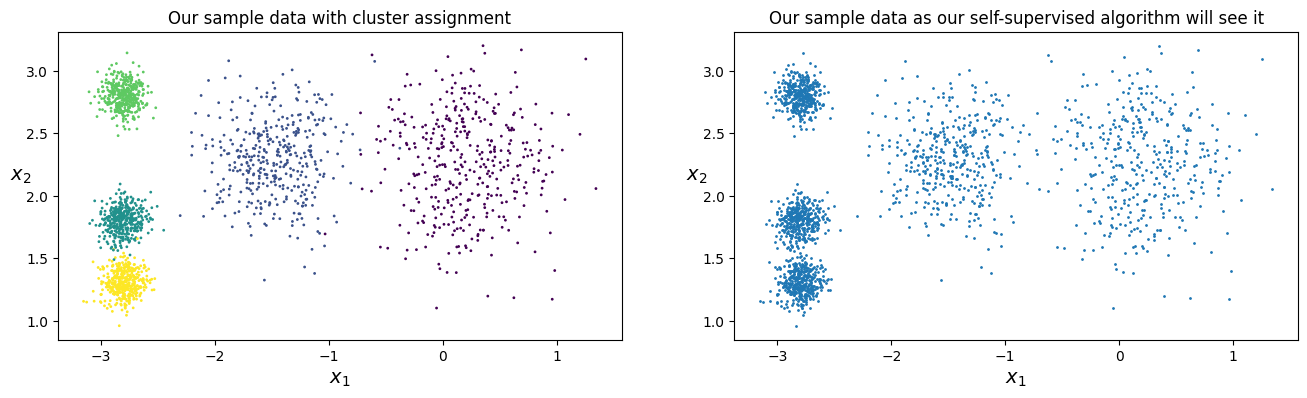

In [6]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plot_clusters(X,y)
plt.title("Our sample data with cluster assignment")
plt.subplot(1,2,2)
plot_clusters(X)
plt.title("Our sample data as our self-supervised algorithm will see it")
plt.show()

**You goal is to recover some similar coloring for each point: point belonging to the same blob should get the same color.**

## 1. Re-implement K-Means
This is a pretty straightforward step. We provide you with the core of the algorithm and you have to code the inner functions.
The public API is the following:

- The `MyKMeans()` constructor accepts two parameters: an random seed (integer) and a number of clusters (`k`).
- The `fit()` method takes a set of samples (our `X` data) and estimates the centers of the `k` clusters.
- The `predict()` method takes as set of samples and predicts the cluster id for each 

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Complete/code the following methods, **in this order**:</b>

1.  `_initialize()`: internal initialization called at the beginning of the fit.
2. `predict()`
3. `fit()`
4. `_compute_inertia()`: computes the sum of squared distances of samples to their closest cluster center.

</div>

### 1.1. Code

In [10]:
class MyKmeans:
    def __init__(self, n_clusters, /, random_state=None, max_iter=300, tol=0.0001):
        '''
        Parameters are the same as Scikit-learn's implementation (for the valid subset).
        
        See: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
        
        Parameters
        ----------
            n_cluster: int
                The number of clusters to form as well as the number of centroids to generate.
            random_state: int, RandomState instance or None, default=None
                Determines random number generation for centroid initialization.
                Use an int to make the randomness deterministic.
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a single run.
            tol: float, default=1e-4
                Relative tolerance with regards to Frobenius norm of the difference in the cluster centers 
                of two consecutive iterations to declare convergence.
        '''
        self.n_clusters = n_clusters
        self._rng = np.random.default_rng(random_state)
        self.max_iter = max_iter
        self.tol = tol
        
        self.cluster_centers_ = None
        self._inertia = None

        
    def _initialize(self, X):
        """
        Initialize cluster centers using samples from X.
        
        Will update the internal field:
        - self.cluster_centers_: np.array of shape (n_clusters, n_features)
            coordinates of cluster centers
        
        Parameters
        ----------
        X: {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster.
        """
        # FIXME #################################################################
        # Randomly select `self.n_clusters` points from `X`.
        # HINT use `self._rng.choice()`. Important parameters: X, size, replace
        # self.cluster_centers_ = ...
        self.cluster_centers_ = self._rng.choice(X, size=self.n_clusters)

    def predict(self, X):
        """
        Predict the closest cluster each sample in X belongs to.
        
        In the vector quantization literature, `cluster_centers_` is called the code book 
        and each value returned by `predict` is the index of the closest code in the code book.
        
        Parameters
        ----------
        X: {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to predict.
        
        Returns
        -------
        labels: ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        if self.cluster_centers_ is None:
            raise RuntimeError("You must call fit() before you can predict().")
        labels = np.zeros(X.shape[0], dtype=np.uint8)
        for ii in range(X.shape[0]):
            # FIXME #################################################################
            # TODO compute the id of the best matching element from `self.cluster_centers_` (lowest L2 distance)
            # HINTS use np.argmin over the L2 distances. Pay attention to the axis parameter!
            
            labels[ii] = np.argmin([np.linalg.norm(cluster_point - X[ii]) for cluster_point in self.cluster_centers_])
        return labels
    
    
    def fit(self, X):
        """
        Compute k-means clustering for a given set of samples.
        
        Will fit the current object and update the following attributes:
        - self.cluster_centers_: np.array of shape (n_clusters, n_features)
            coordinates of cluster centers
        - self._inertia: float
            inertia of the current clustering (could be externalized, used to select the number of clusters)
        - self.n_iter_: int
            number of iterations performed so far
        
        Parameters
        ----------
        X: {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster.
        """
        self._initialize(X)
        center_change = np.infty
        self.n_iter_ = 0
        while self.n_iter_ < self.max_iter and center_change > self.tol:
            # Save a copy (important) of previous centers for comparison
            cluster_centers_prev = self.cluster_centers_.copy()
            # Assign clusters -----
            self._labels = self.predict(X)
            # Compute new center of each cluster -----
            # New center is the mean of all the points falling in this cluster
            for ii in range(self.n_clusters):
                # FIXME #################################################################
                # TODO compute the new cluster center for each cluster
                # HINT it is the center of all points assigned to this cluster
                
                self.cluster_centers_[ii] = np.mean(X[self._labels == ii], axis=0)
                print(f"up cluster {ii}: {cluster_centers_prev[ii]} -> {self.cluster_centers_[ii]}")
                
            
            # Update completion indicators -----
            # Compute the center change
            # Frobenius norm of the element-wise difference in the cluster centers of two consecutive iterations
            center_change = np.sqrt(np.sum((cluster_centers_prev-self.cluster_centers_)**2))
            print(center_change)
            self.n_iter_ += 1
        
        self._inertia = self._compute_inertia(X, self._labels)
        return self
    

    def _compute_inertia(self, X, labels):
        """
        Compute the intertia of the current clustering, given samples `X` and assignments `labels`.
        
        Parameters
        ----------
        X: {array-like, sparse matrix} of shape (n_samples, n_features)
            Instances to compute the inertia for.
        
        labels: np.array of shape (n_samples,) and dtype int
            Labels (aka cluster id, aka id of the cluster center), for each instance, in the current labelling.
        """
        # FIXME #################################################################
        # We take labels as parameter to avoid recomputing the predictions here
        # (labels is assumed to be a previously computed output of self.predict(X))
        
        closest_centers = self.cluster_centers_[labels]
        
        # Inertia is the sum of squared distances of samples to their closest cluster center.
        
        inertia = np.sum((X - closest_centers)**2)
        return inertia

### 1.2. Let us try our implementation

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Run/play with the cells below.</b>

</div>

In [11]:
my_kmeans = MyKmeans(5, random_state=7)

In [12]:
my_kmeans.fit(X)

up cluster 0: [-2.94236285  1.34448388] -> [-2.96780529  1.28284176]
up cluster 1: [-2.78543117  1.83555098] -> [-2.43010492  2.33122772]
up cluster 2: [1.25541552 3.09287413] -> [0.20539504 2.26311308]
up cluster 3: [-2.87620749  1.35218892] -> [-2.82159697  1.30409282]
up cluster 4: [-2.64250251  1.39009855] -> [-2.13215776  1.54763331]
1.5678042506867946
up cluster 0: [-2.96780529  1.28284176] -> [-2.96639634  1.40092575]
up cluster 1: [-2.43010492  2.33122772] -> [-2.43015987  2.59773931]
up cluster 2: [0.20539504 2.26311308] -> [0.13096535 2.27233422]
up cluster 3: [-2.82159697  1.30409282] -> [-2.79201879  1.52038766]
up cluster 4: [-2.13215776  1.54763331] -> [-1.48548493  2.00986423]
0.8775537340477582
up cluster 0: [-2.96639634  1.40092575] -> [-2.854179    1.26642716]
up cluster 1: [-2.43015987  2.59773931] -> [-2.74465662  2.78533496]
up cluster 2: [0.13096535 2.27233422] -> [0.20435039 2.25871099]
up cluster 3: [-2.79201879  1.52038766] -> [-2.78047351  1.67679206]
up clust

In [13]:
my_kmeans.n_iter_

6

In [14]:
my_kmeans._inertia

211.59853725816836

In [15]:
def plot_data_centers_assignments(clusterer, X, resolution=1000):
    '''
    clusterer: centroïd-based clustering object, must have a predict() method and a cluster_centers_ attribute.
    X (np.array, 2D): observations to predict classes for
    '''
    testy = clusterer.predict(X)
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    plot_clusters(X, size=1, label="data")
    plot_clusters(clusterer.cluster_centers_, np.arange(len(clusterer.cluster_centers_)), 
                  size=100, label="centroids")
    plt.title("Original data and learned cluster centroids.")
    plt.legend()
    plt.subplot(1,2,2)
    plot_clusters(X, testy)
    plt.title("Cluster assignments (recovered).")
    plt.show()

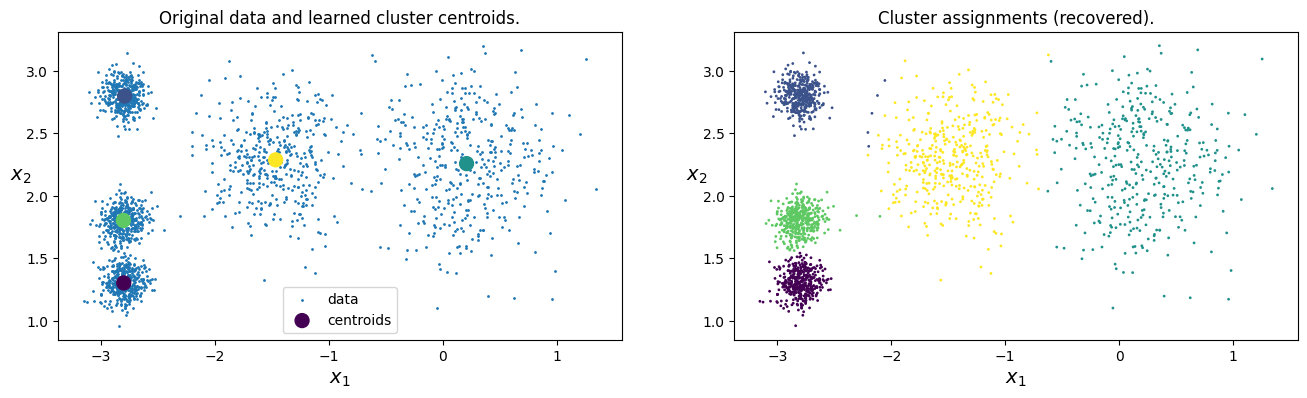

In [16]:
plot_data_centers_assignments(my_kmeans, X)

### 1.3. Compare with scikit-learn's implementation

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Use the same tests as previously with scikit-learn's implementation to compare the outputs.</b>

    
<b>Hints</b>
    
- Import a predictor from `sklearn.cluster`.
- Fit it on our data.
- Display the computed centers, the intertia…
- Use `plot_data_centers_assignments()` to visualize the results.

</div>

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=7, n_init="auto").fit(X)
kmeans.inertia_

223.29108572819044

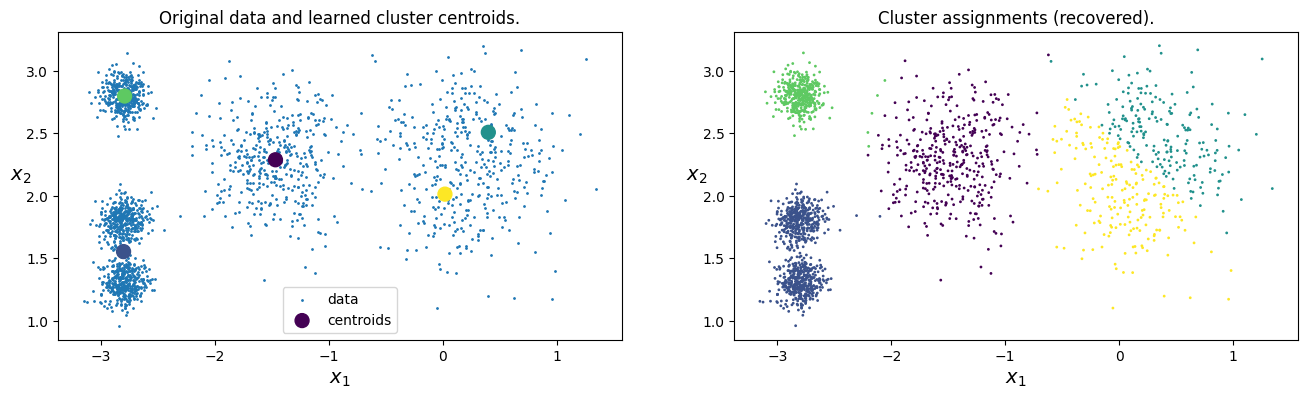

In [24]:
plot_data_centers_assignments(kmeans, X)

## 2. Voronoi diagram

One key strengh of K-Means is to learn parameters which can be used to predict cluster labels for new data.
Using this, we can draw the decision boundaries in the feature space, which gives us a *Voronoi diagram*.

**Note the use of `np.meshgrid()` and of `plt.contour*()` in the code below.**

In [25]:
def plot_decision_boundaries(clusterer, X, resolution=1000):
    '''
    clusterer: centroïd-based clustering object, must have a predict() method and a cluster_centers_ attribute.
    X (np.array, 2D): observations to predict classes for
    '''
    # Generate grid of points
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    # Compute predictions
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot contours (filled and boundaries)
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), alpha=0.5)
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k', alpha=0.5)
    # Plot data
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # Plot centroids
    plt.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],
                marker='o', s=30, linewidths=8,
                color='w', zorder=10, alpha=0.9)
    plt.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1],
                marker='x', s=10, linewidths=10,
                color='k', zorder=11, alpha=1)
    # Axis labels
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

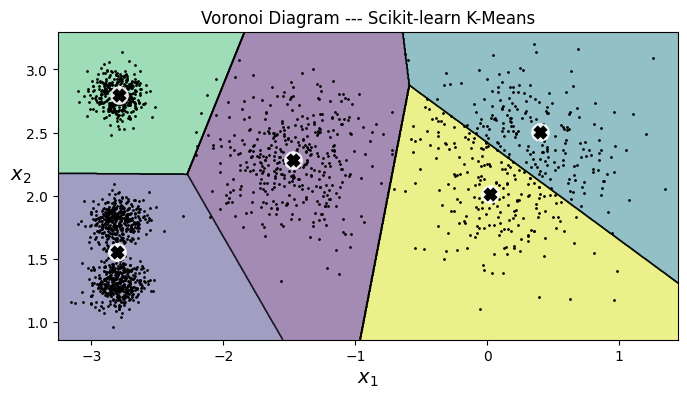

In [26]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)  # FIXME replace sk_kmeans by the name of your sklearn's kmeans
plt.title("Voronoi Diagram --- Scikit-learn K-Means")
plt.show()

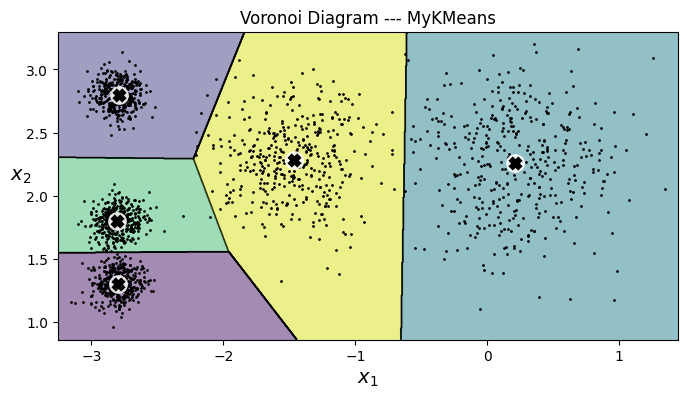

In [27]:
# This is where we generate the figure for the introduction!
plt.figure(figsize=(8, 4))
plot_decision_boundaries(my_kmeans, X)
plt.title("Voronoi Diagram --- MyKMeans")
plt.show()

## 3. Sensitivity to intialization
We will study here the sensitivity of K-Means to initialization.

### 3.1. Bad initialization

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Change the code of your K-Means implementation to pick "bad" cluster centers (i.e. close from each others)
    and study what happens.</b>

</div>

To avoid copy-pasting the whole class, we can simply update the `_initialize()` method of a created object as suggested in the code below.

In [43]:
# Dummy init
my_kmeans_dummyinit = MyKmeans(5)

def stupid_init(self, X):
    # FIXME
 
    self.cluster_centers_ = X[:self.n_clusters]
    print(self.cluster_centers_)
    
my_kmeans_dummyinit._initialize = lambda x: stupid_init(my_kmeans_dummyinit, x)

### 3.2. Common initialization variants

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Try the different `init` parameters of scikit-learn's K-Means implementation.</b>

<b>Hints</b>
- Set `max_iter=1` to see what happens right after initialization (or hack more into the code if possible).
- Set `n_init=1` to avoid multiple runs of the algorithm.
- Use the `plot_decision_boundaries()` function to look at the results.
    
</div>

[[-2.80063241  1.30071377]
 [-2.79290307  2.79641063]
 [ 0.20686405  2.25825338]
 [-2.80357518  1.80145055]
 [-1.46679593  2.28585348]]
up cluster 0: [-2.80063241  1.30071377] -> [-2.80063241  1.30071377]
up cluster 1: [-2.79290307  2.79641063] -> [-2.79290307  2.79641063]
up cluster 2: [0.20686405 2.25825338] -> [0.20686405 2.25825338]
up cluster 3: [-2.80357518  1.80145055] -> [-2.80357518  1.80145055]
up cluster 4: [-1.46679593  2.28585348] -> [-1.46679593  2.28585348]
8.982402180781215e-11


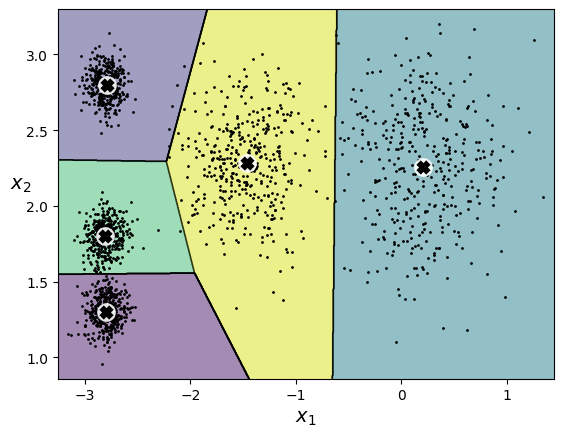

In [44]:

my_kmeans_dummyinit.fit(X)
plot_decision_boundaries(my_kmeans_dummyinit,X)

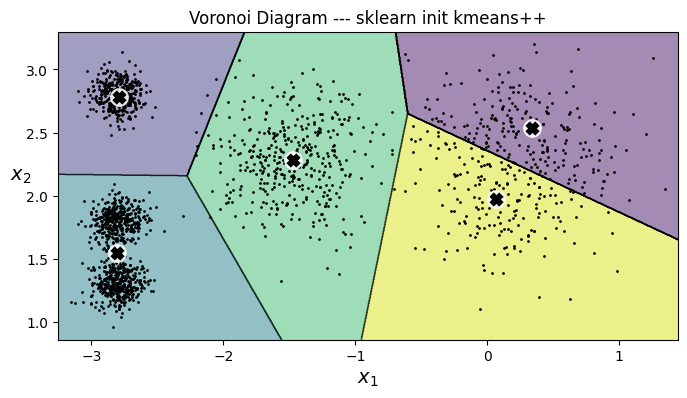

In [40]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(KMeans(5,max_iter=1,init='k-means++',n_init=1).fit(X), X)
plt.title("Voronoi Diagram --- sklearn init kmeans++")
plt.show()

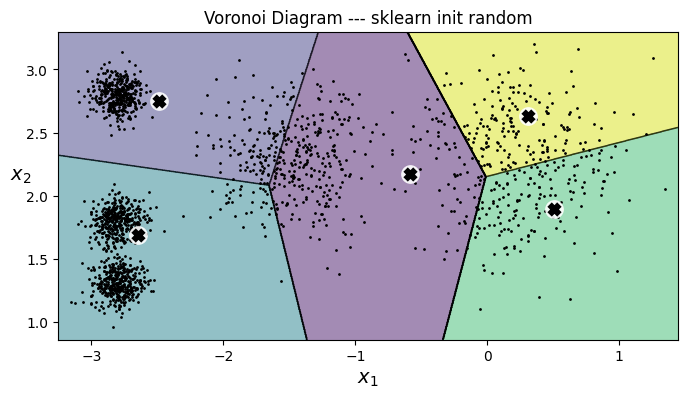

In [41]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(KMeans(5,max_iter=1,init='random',n_init=1,random_state=2).fit(X), X)
plt.title("Voronoi Diagram --- sklearn init random")
plt.show()

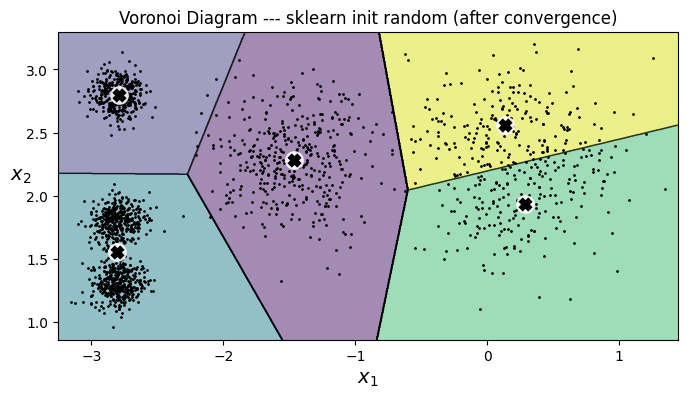

In [42]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(KMeans(5,init='random',n_init=1,random_state=2).fit(X), X)
plt.title("Voronoi Diagram --- sklearn init random (after convergence)")
plt.show()

## 4. Impact of the number of cluster

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>For a range of number of clusters, study the results obtained and the evolution of the inertia.</b>

<b>Hints</b>
- The inertia is available with `clusterer.inertia_` after the training (call to `fit()`).
- Plotting the Voronoi diagram for each cluster value can be done with `plot_decision_boundaries()`.
- Plot the number of clusters vs inertia with a simple `plt.plot()`.
    
</div>

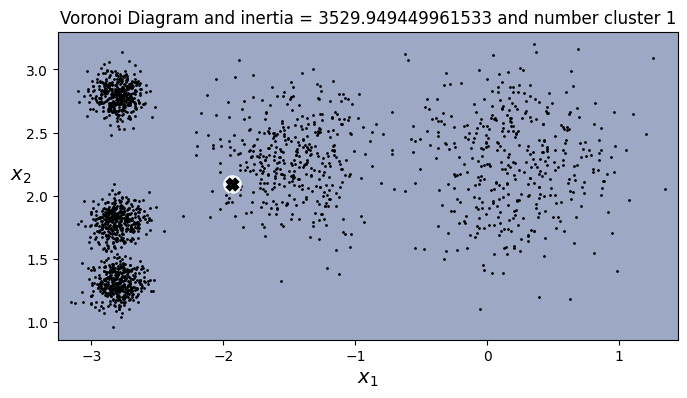

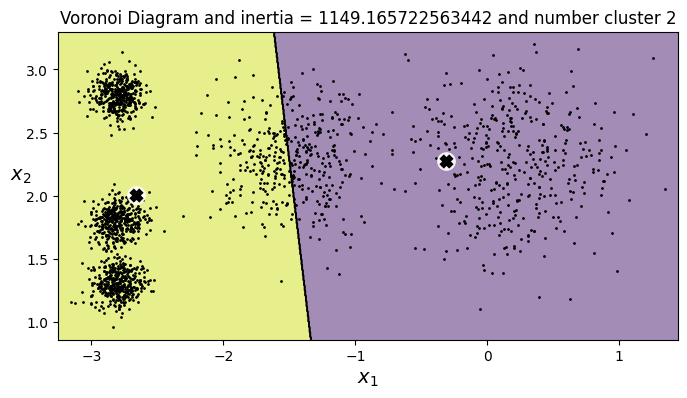

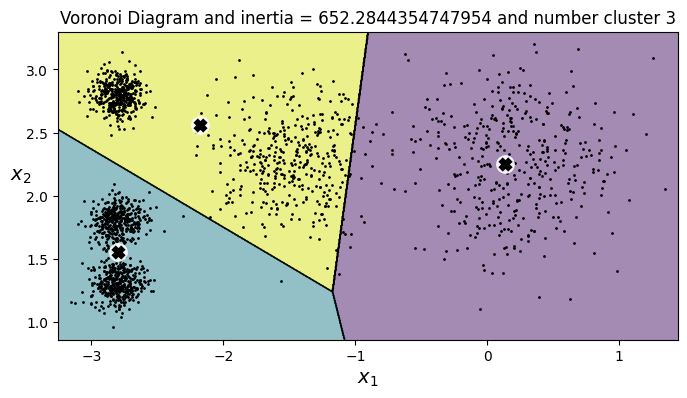

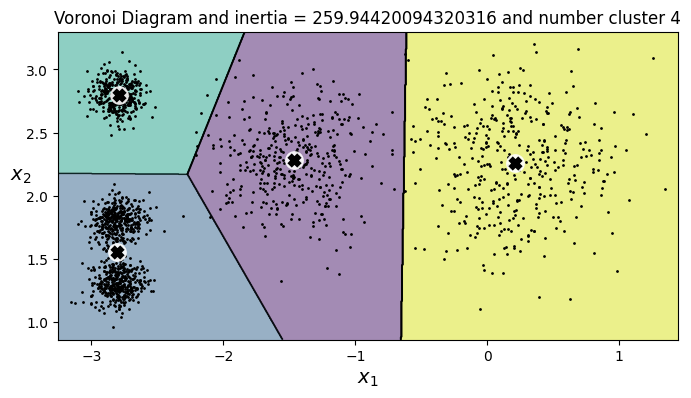

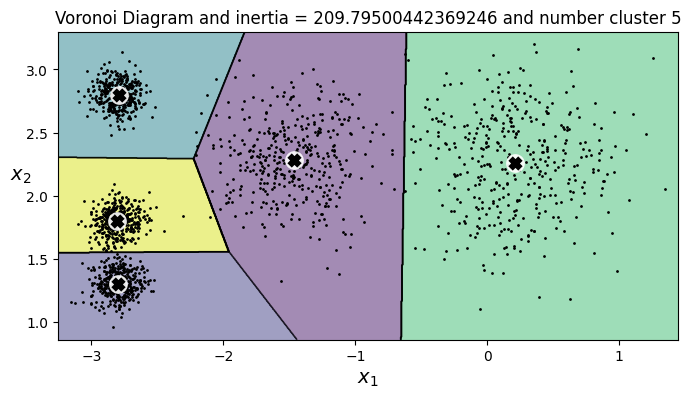

In [49]:
for i in range(1, 6):
    tmp = KMeans(n_clusters=i, random_state=7, n_init="auto").fit(X)
    plt.figure(figsize=(8, 4))
    plot_decision_boundaries(tmp, X)
    txt = str(tmp.inertia_) + " and number cluster " + str(i)
    plt.title("Voronoi Diagram and inertia = "+txt)
plt.show()

## 5. K-Means limits
Let's apply some anisotropic deformation to our blobs.

In [51]:
# From https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html
# transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
transformation = [[0.6, -0.7], [-0.2, 0.9]]
X_aniso = np.dot(X, transformation)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

<b>Try to fit a K-Means. What happens? Why?</b>

    
</div>

Text(0.5, 1.0, 'Voronoi Diagram and inertia = 147.33237575631796')

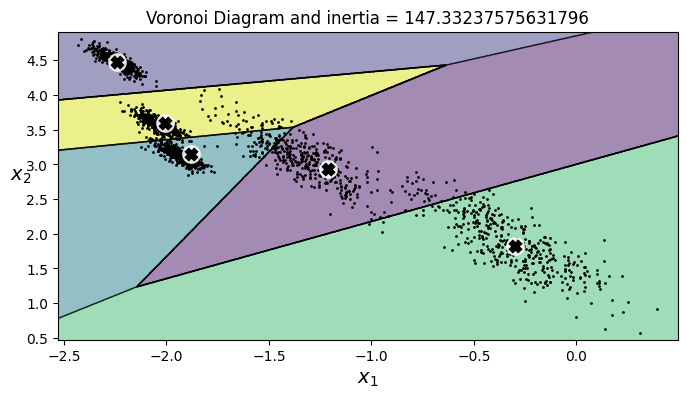

In [61]:
tmp = KMeans(n_clusters=5, random_state=7, n_init="auto").fit(X_aniso)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(tmp, X_aniso)
txt = str(tmp.inertia_)
plt.title("Voronoi Diagram and inertia = "+txt)

# Good job!
You are now ready to move on to the next part.